In [1]:
import ROOT

Welcome to JupyROOT 6.26/04


In [16]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import beta

In [526]:
d = ROOT.RDataFrame("TimedTrackStorage", "run7232_merged_energyest.root")

In [528]:
import uproot
file = uproot.open("run7232_merged_energyest.root")

# Functions

In [942]:
# renames columns from default name given by uproot
def colRename(col_name): 
    col_name = str(col_name)
    col_name = col_name.replace("'", "")
    col_name = col_name.replace("(", "")
    col_name = col_name.replace(")", "")
    if "." in col_name:
        col_name = col_name.split(".", 1)[1]
    x = col_name.split(", ")
    if x[1]=='':
        return x[0]
    else:
        return x[0] + "_" + x[1]

In [948]:
# "exact" Clopper-Pearson interval inspired by TEfficiency documentation

# gets lower errorbar endpoint
def binom_int_low(num,den, confint=conf):
    quant = (1 - confint)/ 2.
    low = beta.ppf(quant, num, den - num + 1)
    return np.nan_to_num(low)

# gets upper errorbar endpoint
def binom_int_high(num,den, confint=conf):
    quant = (1 - confint)/ 2.
    high = beta.ppf(1 - quant, num + 1, den - num)
    return np.where(np.isnan(high), 1, high)

# Load Data

In [1019]:
# West cryostat dataset
treeW = file["TimedTrackStorageW"]
df_W = treeW.arrays(library="pd")
df_W = df_W.rename(colRename, axis='columns')
# East cryostat dataset
treeE = file["TimedTrackStorageE"]
df_E = treeE.arrays(library="pd")
df_E = df_E.rename(colRename, axis='columns')

pandas.set_option('display.max_columns', None)

# Efficiency Plots

In [1191]:
cryostat = 'W'
df = df_W if cryostat=='W' else df_E

# all rows with subentry = 0 from original df
# gets rid of double counting from flashes
df_u = df.xs(0, level='subentry')

In [1192]:
# trigger categories + corresponding colors for plot
type = ["M1", "S3", "S5", "S8", "S10", "S15"]
color = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
#type = ["S3", "S5", "S10"]

In [1193]:
# VALUES TO SET BEFORE RUN
# desired confidence interval
conf = 0.6827

# cutoff ratio, all selected values must be more extreme than cutoff
cutoff = 0.75

In [1194]:
# add ratio columns
var1 = "start_x"
var2 = "end_x"

# only count events within the interval where data is being collected (otherwise the trigger will obviously not fire)
df_time = df_u[df_u["t0"].between(-55, 75)]

x_start = df_time[var1].to_numpy()
x_end = df_time[var2].to_numpy()

# define east and west x-positions
df_time.insert(49, 'x_w', np.maximum(x_start, x_end))
df_time.insert(50,'x_e', np.minimum(x_start, x_end))

x_cathode = 210 if cryostat=='W' else -210

# define x-distance from cathode of east and west x-positions
# if tracks don't quite reach the cathode, change one x-coordinate to be at the cathode
df_time.insert(51, 'dx_w', np.maximum(df_time['x_w'] - x_cathode, 0))
df_time.insert(52, 'dx_e', np.maximum(x_cathode - df_time['x_e'], 0))

df_time.insert(53,'ratio_x', (df_time['dx_w'] - df_time['dx_e']) / (df_time['dx_e'] + df_time['dx_w']))

var = 'ratio_x'


df_west = df_time[df_time['ratio_x'] > cutoff]
df_east = df_time[df_time['ratio_x'] < -1*cutoff]
print(len(df_time), len(df_east), len(df_west))

28357 2311 2301


In [1205]:
# VALUES TO SET BEFORE RUN
# choose df_time, df_east, or df_west (if east or west select desired cutoff ratio above)
df_c = df_time

var = 'length'
var_label = "Track length"
var_units = "(cm)" # this should be in parenthesis
bin_size=5

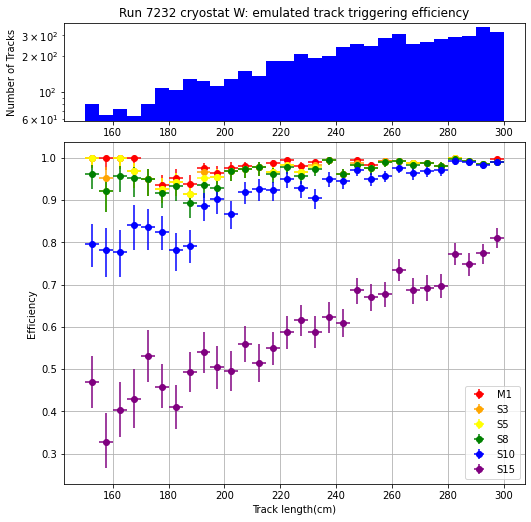

In [1206]:
# equal binned version

# set up figure and panels
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 1, height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.2, hspace=0.1)
ax = fig.add_subplot(gs[1, 0])
ax_hist = fig.add_subplot(gs[0, 0], sharex=ax)

# maximum length, rounded up to the nearest bin size
max_val = max(df_c[var])
max_val = int(np.ceil(max_val/bin_size)*bin_size)
max_val=300
min_val = min(df_c[var])
min_val = int(np.floor(min_val/bin_size)*bin_size)
min_val=150

bin_arr = np.arange(min_val, max_val, bin_size)

for t in range(0, len(type)):
    t_type = type[t] # trigger type chosen for this histogram
    label = t_type + "_fired"
    trig = df_c[df_c[label] == True]
    notTrig = df_c[df_c[label] == False]
    
    # counts of triggered and not triggered events in the bin
    bin_trig = [len(trig[(bin_arr[i]<=trig[var]) & (trig[var]<bin_arr[i]+bin_size)]) for i in range(len(bin_arr))]
    bin_notTrig = [len(notTrig[(bin_arr[i]<=notTrig[var]) & (notTrig[var]<bin_arr[i]+bin_size)]) for i in range(len(bin_arr))]

    # total number of events in the bin
    bin_tot = np.add(bin_trig, bin_notTrig)
    # adjust sizes of triggered, not triggered, and bin lists to eliminate bins with 0 events
    bin_trig = [bin_trig[i] for i in range(len(bin_arr)) if bin_tot[i]!=0]
    bin_notTrig = [bin_notTrig[i] for i in range(len(bin_arr)) if bin_tot[i]!=0]
    bin_arr = [bin_arr[i] for i in range(len(bin_arr)) if bin_tot[i]!=0]
    
    # compute efficiency for each bin
    eff_arr = np.divide(bin_trig, (np.add(bin_trig, bin_notTrig)))
   
    # compute errors corresponding to efficiency values using the exact Clopper-Pearson method
    # use asymmetric error so that the error bars don't extend above 1
    low_CI = [binom_int_low(bin_trig[i], bin_trig[i] + bin_notTrig[i]) for i in range(len(bin_trig))]
    high_CI = [binom_int_high(bin_trig[i], bin_trig[i] + bin_notTrig[i]) for i in range(len(bin_trig))]
    high_yerr_arr = np.subtract(high_CI, eff_arr)
    low_yerr_arr = np.subtract(eff_arr, low_CI)
    asymm_err = [low_yerr_arr, high_yerr_arr]
    
    # plot the error bars
    ax.errorbar([(i+bin_size/2) for i in bin_arr], eff_arr, xerr = bin_size/2, yerr = asymm_err, label = t_type, fmt='o', color=color[t])
# scatterplot axes labels and legend
ax.legend(loc="lower right")

# DON'T FORGET TO UPDATE THIS
ax.set_xlabel(var_label + var_units)
ax.set_ylabel("Efficiency")

# plot title
dir_rel_cathode = ", W of cathode" if df_c.equals(df_west) else ", E of cathode" if df_c.equals(df_east) else ""
plt.title("Run 7232 cryostat " + cryostat + dir_rel_cathode + ": emulated track triggering efficiency")

# plot the histogram of counts
ax_hist.bar([(i+bin_size/2) for i in bin_arr], bin_tot, width=bin_size, color=color[4], log=True)
ax_hist.set_ylabel("Number of Tracks")
ax.grid()

ratio_val = '_ratio_x_'+str(-1*cutoff) if df_c.equals(df_west) else '_ratio_x_'+str(cutoff) if df_c.equals(df_east) else ""

# show and save the figure
plt.savefig('efficiency_plots/efficiency_'+var+'_7232mer'+cryostat+ratio_val+'_'+"eff_drop_"+str(conf)+'CI.pdf')
plt.show()

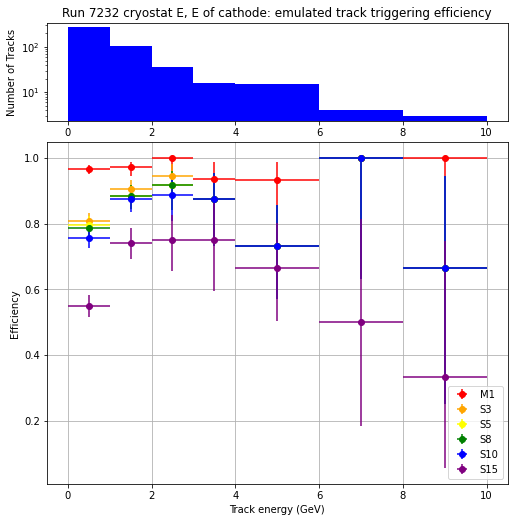

In [1163]:
# re-binning version

fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 1, height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.2, hspace=0.1)

ax = fig.add_subplot(gs[1, 0])
ax_hist = fig.add_subplot(gs[0, 0], sharex=ax)

# CHANGE THIS FOR DESIRED VARIABLE
bin_arr = [0, 1000, 2000, 3000, 4000, 6000, 8000] 
bin_size = np.append(np.ediff1d(bin_arr),2000) # add size of last bin here

for t in range(0, len(type)):
    t_type = type[t] # trigger type chosen for this histogram
    label = t_type + "_fired"
    trig = df_c[df_c[label] == True]
    notTrig = df_c[df_c[label] == False]
    
    
    # counts of triggered and not triggered events in the bin
    bin_trig = [len(trig[(bin_arr[i]<=trig[var]) & (trig[var]<bin_arr[i]+bin_size[i])]) for i in range(len(bin_arr))]
    bin_notTrig = [len(notTrig[(bin_arr[i]<=notTrig[var]) & (notTrig[var]<bin_arr[i]+bin_size[i])]) for i in range(len(bin_arr))]

    # total number of events in the bin
    bin_tot = np.add(bin_trig, bin_notTrig)
    # adjust sizes of triggered, not triggered, and bin lists to eliminate bins with 0 events
    bin_trig = [bin_trig[i] for i in range(len(bin_arr)) if bin_tot[i]!=0]
    bin_notTrig = [bin_notTrig[i] for i in range(len(bin_arr)) if bin_tot[i]!=0]
    bin_size = np.array([bin_size[i] for i in range(len(bin_arr)) if bin_tot[i]!=0])
    bin_arr = [bin_arr[i] for i in range(len(bin_arr)) if bin_tot[i]!=0]

    # compute efficiency for each bin
    eff_arr = np.divide(bin_trig, (np.add(bin_trig, bin_notTrig)))
   
    # compute errors corresponding to efficiency values using the exact Clopper-Pearson method
    # use asymmetric error so that the error bars don't extend above 1
    low_CI = [binom_int_low(bin_trig[i], bin_trig[i] + bin_notTrig[i]) for i in range(len(bin_trig))]
    high_CI = [binom_int_high(bin_trig[i], bin_trig[i] + bin_notTrig[i]) for i in range(len(bin_trig))]
    high_yerr_arr = np.subtract(high_CI, eff_arr)
    low_yerr_arr = np.subtract(eff_arr, low_CI)
    asymm_err = [low_yerr_arr, high_yerr_arr]
    
    # plot the error bars
    ax.errorbar([(bin_arr[i]+bin_size[i]/2)*1e-3 for i in range(len(bin_arr))], eff_arr, xerr = bin_size/2*1e-3, yerr = asymm_err, label = t_type, fmt='o', color=color[t])
    
# scatterplot axes labels and legend
ax.legend(loc="lower right")

# DON'T FORGET TO UPDATE THIS
ax.set_xlabel(var_label + " " + var_units)
ax.set_ylabel("Efficiency")

# plot title
dir_rel_cathode = ", W of cathode" if df_c.equals(df_west) else ", E of cathode" if df_c.equals(df_east) else ""
plt.title("Run 7232 cryostat " + cryostat + dir_rel_cathode + ": emulated track triggering efficiency")

# plot the histogram of counts
ax_hist.bar([(bin_arr[i]+bin_size[i]/2)*1e-3 for i in range(len(bin_arr))], bin_tot, width=bin_size*1e-3, color=color[4], log=True)
ax_hist.set_ylabel("Number of Tracks")
ax.grid()

ratio_val = '_ratio_x_'+str(-1*cutoff) if df_c.equals(df_west) else '_ratio_x_'+str(cutoff) if df_c.equals(df_east) else ""

# show and save the figure
plt.savefig('efficiency_plots/efficiency_'+var+'_7232mer'+cryostat+ratio_val+'_'+str(conf)+'CI.pdf')
plt.show()

# Histograms

<BarContainer object of 10 artists>

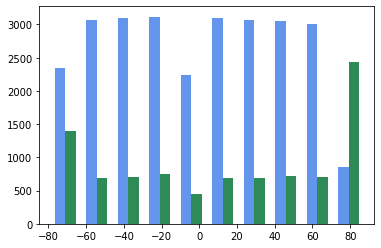

In [946]:
# make histogram of triggered v. non-triggered counts by length bins
t_type = "S15" # trigger type chosen for this histogram
label = t_type + "_fired"
trig = df_u[df_u[label] == True]
notTrig = df_u[df_u[label] == False]

var = "t0"
fig, ax = plt.subplots()

trig_heights, trig_bins = np.histogram(trig[var])
notTrig_heights, notTrig_bins = np.histogram(notTrig[var], bins=trig_bins)


width = (trig_bins[1] - trig_bins[0])/3

ax.bar(trig_bins[:-1], trig_heights, width=width, facecolor='cornflowerblue')
ax.bar(notTrig_bins[:-1]+width, notTrig_heights, width=width, facecolor='seagreen')

1.0732389688491821 412.0295715332031
0
316825


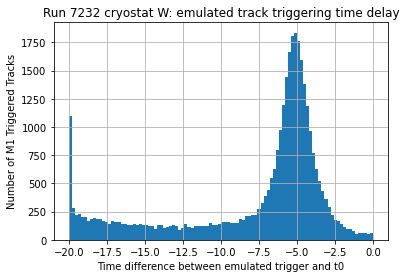

In [878]:
var = 'end_x'
print(min(df_u[var]), max(df_u[var]))
print(len(df_u[(500<=df_u[var]) & (df_u[var]<=max(df_u[var]))]))
print(len(df_u[var]))


fig, ax = plt.subplots()

df_M1 = df_u[df_u['M1_fired']]
diff = df_M1['M1_time']-df_M1['t0']-1500 # 20 microsecond range, emulation only considers 20 us around track time for trigger
# electronics time starts 1500 us before trigger, fixed
# t0 time bigger, time alignment not great
# evaluate trigger before t0 because of time offsets
# np.mean(diff) # avg delay b/w
diff.hist(bins=100)

ax.set_xlabel("Time difference between emulated trigger and t0")
ax.set_ylabel("Number of M1 Triggered Tracks")

# plot title
plt.title("Run 7232 cryostat W: emulated track triggering time delay")
plt.savefig('other_plots/hist_M1time-t0_7232merW.pdf') # can powerpoint import pdf?

-435.5328063964844 -26.814603805541992
0
251891


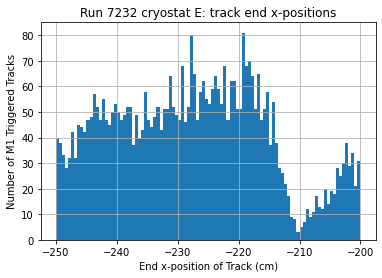

In [745]:
var = 'end_x'
print(min(df_u[var]), max(df_u[var]))
print(len(df_u[(500<=df_u[var]) & (df_u[var]<=max(df_u[var]))]))
print(len(df_u[var]))


fig, ax = plt.subplots()

arr = df_time[var]
arr.hist(bins=100, range=(-250, -200))



ax.set_xlabel("End x-position of Track (cm)")
ax.set_ylabel("Number of M1 Triggered Tracks")

# plot title
plt.title("Run 7232 cryostat W: track end x-positions")
plt.savefig('other_plots/hist_end_x_7232merW.pdf')

138.25186290895664


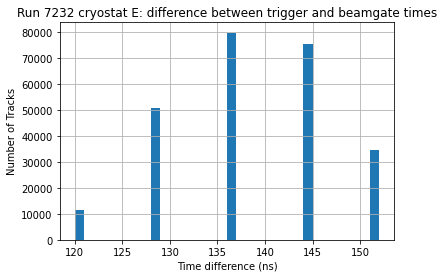

In [897]:
fig, ax = plt.subplots()
diff = df_u['triggerTime']-df_u['beamGateTime']
diff.hist(bins=32)
print(np.mean(diff))
ax.set_ylabel("Number of Tracks")
ax.set_xlabel("Time difference (ns)")
ax.set_title("Run 7232 cryostat E: difference between trigger and beamgate times")
plt.savefig('other_plots/hist_trig-beamgate_7232merE.pdf', bbox_inches='tight')

1638311234.6799462
0.000355328
22237.807468288


Text(0.5, 1.0, 'Run 7232 cryostat W: emulated track triggering efficiency')

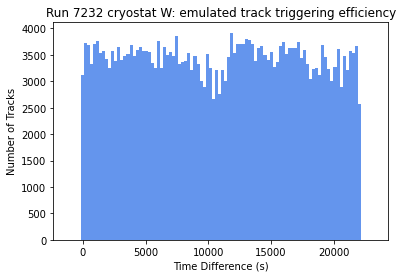

In [284]:
# histogram of difference between triggerTime and t0 for all tracks
# not sure if I'm doing this right...

var1 = "triggerTime" # in nanoseconds
var2 = "t0" # in microseconds
fig, ax = plt.subplots()
print(min(df_u[var1])*1e-9)
diff = (df_u[var1]-(df_u[var2]*1e3)-min(df_u[var1]))*1e-9
print(min(diff))
print(max(diff))
heights, bins = np.histogram(diff, bins=100, range=(-1e3, max(diff)+1e3))

width = (bins[1] - bins[0])

ax.bar(bins[:-1], heights, width=width, facecolor='cornflowerblue')
ax.set_xlabel("Time Difference (s)")
ax.set_ylabel("Number of Tracks")
plt.title("Run 7232 cryostat W: emulated track triggering efficiency")

In [36]:
bw = df_time[df_time['length'].between(0, 100)]
bwm1 = len(bw[bw["M1_fired"]==False])
bws3 = len(bw[bw["S3_fired"]==False])
bws5 = len(bw[bw["S5_fired"]==False])
bws8 = len(bw[bw["S8_fired"]==False])
bws10 = len(bw[bw["S10_fired"]==False])
bws15 = len(bw[bw["S15_fired"]==False])
print(bwm1, bws3, bws5, bws8, bws10, bws15)

26 45 76 169 212 285


# To-do Lists

## 6/28 To-do:
1. how many tracks do we have? ✅

2. change column names ✅

3. make histograms of total number of tracks per length & ones that triggered/didn't ✅

4. draw an efficiency vs track length plot ✅
    - efficiency is w/ triggered data
    - F in denom, T in num & denom
    - don't hardcode trigger settings
    - Error bars:
        - binomial dist for errors
        - cases with only 1 track / 100% efficiency handle error separately
        - root TEfficiency for errors? consider
        
~~Problem~~: Why are my efficiencies all so small (<0.2)? Do I need to only count those tracks that occur within some trigger time? What variable is that? Choosing only t0 within -70 to 70 gives efficiencies ~50% for all lengths, so that doesn't seem like the right choice

Efficiency formula:

e = $\frac{\textrm{(TPC tracks with CRT hit and with light info)} × \textrm{(which would fire the trigger)}}{\textrm{(TPC tracks with CRT hit and with light info)}}$ = $\frac{\textrm{Track in df_time that triggered}}{\textrm{Track in df_time (triggered or not)}}$

df_time is the variation of the original dataset that eliminates the subentries column (and hence duplicate rows from the same event) and only keeps rows with t0 between -55 and 55 (for this minimum bias run with 150 µs of recording time, and so these are the only possible times during which triggering can happen, adding some buffer). 

## 6/29 To-do:
1. offset between trigger time and track time? emulated trigger centers on track of time ✅
    - imposing a bias, should find trigger time is never more than so much away from time of track
    - not sure I did it right - got a range of about 1 million seconds which seems like a lot...?
2. efficiency v. other variables ✅
    - energy is weird though - there's a ton of very low energy tracks and very few high energy ones, spread over a very large range from about 10kJ to about 1.5MJ - I chose to only consider up to 10kJ which I think captures most of the tracks - 23427 out of 23899 events are captured in the plot.
3. compare with jacob's plot ✅
    - not sure exactly what statistical model jacob used but the recommended Clopper-Pearson interval got me pretty close
4. check root documentation for error inspiration for when error is 0 - TEfficiency documentation ✅
    - clopper-pearson exact interval was recommended so I used that
5. store data in git repository ✅
6. include histogram of number of tracks in each bin ✅

## 6/30 To-do:
1. consider trigger efficiency as a function of x ✅
    - tried start and end x, they look really similar
    - both are bimodal, highest efficiency around x=100 & x=300
2. plot trigger efficiency as a function of z ✅
    - overall more efficient closer to z=0
3. plot trigger efficiency as function of the balance of energy deposition on the two sides of the cathode - tomorrow ✅
    - what data to use?
    - use start + end positions of track & assume straight line - then, need to know cathode x position
        - then assume constant dE/dx ≈ 2.2 for energy deposition estimate on either side of cathode
    - use ratio of energy deposition $\frac{\textrm{Energy deposition of track section with } x > x_\textrm{cathode}}{\textrm{Energy deposition of track section with } x < x_\textrm{cathode}}$ as variable?
4. prepare a first report of the work I have done so far in the form of slides for a presentation -- the standard form includes motivation, methodology and results ✅
5. clarify offset in trigger time & t0 from yesterday - weird results ✅
    - figure out first peak in M1_time - t0 histogram

## 7/1 To-do:
1. plot trigger efficiency as function of the balance of energy deposition on the two sides of the cathode (simplified version to start) ✅
    - don't have dQ/dx data and cathode intersection location not yet in the tree
    - use ratio of distance of track endpoints from cathode $\frac{\textrm{Distance from cathode of track endpoint with } x > x_\textrm{cathode}}{\textrm{Distance from cathode of track endpoint with } x < x_\textrm{cathode}}$ as variable
        - get $x_\textrm{cathode}$ from the distribution of x - look at histogram
            - CONFUSION - there doesn't seem to be a single cathode value such that all the tracks cross it...
        - if mixing east and west cryostats (which I wasn't) then remember there are two different cathodes
2. add this exploration to the presentation ✅

## 7/5 To-do:
1. repeat all plots with cryostat E data from run 7232 ✅
    - for the ratio, added a - sign to keep with convention from cryostat W (1 means East of cathode, -1 means West of cathode)
2. fix backwards East/West in above plots ✅
3. automate naming of stuff in code to make running easier ✅
4. zoom in on drop in efficiency for length w/ E and W cryostats ✅
5. Fix powerpoint to have side-by-side comparisons for E & W cryostats